In [1]:
import matplotlib.cm as cm
from time import time
from matplotlib import lines as mlines
import numpy as np
from jax import random as jran

ran_key = jran.PRNGKey(180)

In [2]:
import os
from astropy.table import Table
diffprof_drn = "/Users/aphearin/work/DATA/diffprof_data"
mdpl2 = Table.read(os.path.join(diffprof_drn, "MDPL2_halo_table.hdf5"))
bpl = Table.read(os.path.join(diffprof_drn, "BPL_halo_table.hdf5"))
print(bpl.keys())

['halo_id', 'conc_beta_early', 'conc_beta_late', 'conc_k', 'conc_lgtc', 'u_conc_beta_early', 'u_conc_beta_late', 'u_conc_k', 'u_conc_lgtc', 'logmp', 'mah_early', 'mah_late', 'mah_logtc', 'mah_k', 'log_mah_fit', 'conch_fit', 'tform_50', 'p_tform_50']


In [3]:
from diffprof.nfw_evolution import lgc_vs_lgt

lgc_vs_lgt_vmap = jjit(jvmap(lgc_vs_lgt, in_axes=(None, 0, 0, 0, 0)))

N_T = 25
TARR_FIT = np.linspace(3.5, 13.8, N_T)

lgconc_history_bpl = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), bpl["conc_lgtc"], bpl["conc_k"], bpl["conc_beta_early"], bpl["conc_beta_late"]))
lgconc_history_mdpl2 = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), mdpl2["conc_lgtc"], mdpl2["conc_k"], mdpl2["conc_beta_early"], mdpl2["conc_beta_late"]))


In [4]:
from diffprof.latin_hypercube import get_scipy_kdtree, retrieve_lh_sample_indices
tree_bpl = get_scipy_kdtree(bpl['logmp'])
tree_mdpl2 = get_scipy_kdtree(mdpl2['logmp'])

indx_bpl = retrieve_lh_sample_indices(tree_bpl, 11.35, 13.65, 1, 100_000)
indx_mdpl2 = retrieve_lh_sample_indices(tree_mdpl2, 13.4, 14.6, 1, 100_000)

In [5]:
from diffprof.get_target_simdata import target_data_generator

N_MH_TARGETS, N_P_TARGETS = 10, 15

args = (bpl['logmp'][indx_bpl],
    mdpl2['logmp'][indx_mdpl2],
    lgconc_history_bpl[indx_bpl],
    lgconc_history_mdpl2[indx_mdpl2],
    bpl['p_tform_50'][indx_bpl],
    mdpl2['p_tform_50'][indx_mdpl2],
    N_MH_TARGETS,
    N_P_TARGETS,
       )
gen = target_data_generator(*args, lgmh_min=12.25, lgmh_max=14.5, p50_min=0.1, p50_max=0.9)

In [6]:
target_data = next(gen)
lgmhalo_targets, p50_targets = target_data[0:2]
target_avg_log_conc_lgm0, target_std_log_conc_lgm0 = target_data[2:4]
target_avg_log_conc_p50_lgm0, _target_std_log_conc_p50_lgm0 = target_data[4:]

In [7]:
from dev_new_loss import _get_grid_data
from diffprof.dpp_opt import get_u_param_grids

n_grid = 2500
grid_key, ran_key = jran.split(ran_key, 2)
u_be_grid, u_lgtc_bl_grid = get_u_param_grids(grid_key, n_grid)

grid_data = _get_grid_data(p50_targets, TARR_FIT, u_be_grid, u_lgtc_bl_grid)

In [8]:
from diffprof.bpl_dpp import DEFAULT_PARAMS
dpp_params = np.array(list(DEFAULT_PARAMS.values()))

In [9]:
from dev_new_loss import _mse_loss_multimass

_mse_loss_multimass(
    dpp_params, grid_data, lgmhalo_targets, 
    target_avg_log_conc_p50_lgm0, target_avg_log_conc_lgm0, target_std_log_conc_lgm0)

DeviceArray(0.0419875, dtype=float32)

In [10]:
from diffprof.fitting_helpers.utils import jax_adam_wrapper
from dev_new_loss import _global_loss_func

global_loss_data = (grid_data, lgmhalo_targets, target_avg_log_conc_p50_lgm0,
                    target_avg_log_conc_lgm0, target_std_log_conc_lgm0)
_global_loss_func(dpp_params, global_loss_data)


DeviceArray(0.0419875, dtype=float32)

In [14]:
from jax import value_and_grad

_global_loss_func_and_grad = value_and_grad(_global_loss_func, argnums=0)
_global_loss_func_and_grad(dpp_params, global_loss_data)


(DeviceArray(0.0419875, dtype=float32),
 DeviceArray([-2.2738332e-04, -1.8317347e-04,  0.0000000e+00,
               1.5584535e-02,  4.0276363e-02,  3.8385794e-02,
              -2.0394367e-03, -2.1626712e-03,  1.5869583e-03,
               1.5766197e-03,  6.0215534e-05,  6.8461726e-05,
               9.4727264e-04,  1.1531706e-03, -6.1068614e-04,
              -6.6237990e-04, -1.8160467e-04, -1.9964800e-04,
              -6.1276101e-02, -6.6057540e-02,  3.0931115e-02,
               3.0642170e-02,  5.7976344e-04,  6.3219003e-04,
              -7.6020238e-05, -6.7934205e-05,  7.2569363e-03,
              -4.5228102e-03, -9.1301417e-03, -2.3700021e-02,
               4.9226190e-05,  2.4835881e-02, -6.8975822e-03],            dtype=float32))

In [19]:
n_steps = 250
_res = jax_adam_wrapper(_global_loss_func, dpp_params, global_loss_data, n_steps, n_warmup=0)
p_best, loss, loss_history = _res[:3]

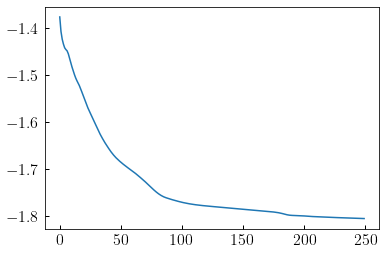

In [20]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(np.log10(loss_history))

In [22]:
np.save('new_p_best', p_best)